In [ ]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

Downloading dataset containing 25.000 reviews with appropriate label coresponding to its negative (0) or positive (1) meaning.

In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

In [ ]:
dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url, untar=True, cache_dir='.' ,cache_subdir='.')
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [ ]:
os.listdir(dataset_dir)

['train', 'imdbEr.txt', 'README', 'test', 'imdb.vocab']

In [ ]:
train_dir = os.path.join(dataset_dir, 'train')

In [ ]:
os.listdir(train_dir)

['urls_pos.txt',
 'unsup',
 'unsupBow.feat',
 'pos',
 'urls_unsup.txt',
 'labeledBow.feat',
 'urls_neg.txt',
 'neg']

In [ ]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')

In [ ]:
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [ ]:
remove_dir = os.path.join(train_dir, 'unsup')

In [ ]:
shutil.rmtree(remove_dir)

In [ ]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory('aclImdb/train',
                                                                  batch_size = batch_size,
                                                                  seed = seed,
                                                                  validation_split = 0.2,
                                                                  subset = 'training')

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print('Review', text_batch.numpy()[i])
    print('Label', label_batch.numpy()[i])

Review b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />There\'s a 

In [ ]:
print('label 0 corresponds to ', raw_train_ds.class_names[0])
print('label 1 corresponds to ', raw_train_ds.class_names[1])

label 0 corresponds to  neg
label 1 corresponds to  pos


In [ ]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory('aclImdb/train',
                                                                batch_size = batch_size,
                                                                seed = seed,
                                                                validation_split = 0.2,
                                                                subset = 'validation')

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory('aclImdb/test',
                                                                 batch_size = batch_size)

Found 25000 files belonging to 2 classes.


In [ ]:
def custom_standarization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase,'<br />', ' ')
  return tf.strings.regex_replace(stripped_html,'[%s]' % re.escape(string.punctuation), ' ')

In [ ]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(standardize = custom_standarization,
                                    max_tokens = max_features,
                                    output_mode = 'int',
                                    output_sequence_length = sequence_length)

In [ ]:
train_text = raw_train_ds.map(lambda x, y:x)
vectorize_layer.adapt(train_text)

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label


In [ ]:
text_batch, label_batch = next(iter(raw_train_ds))
first_text, first_label = text_batch[0], label_batch[0]
print('first_review: ', first_text)
print('first_label: ', raw_train_ds.class_names[first_label])
print('vectorized review: ', vectorize_text(first_text, first_label))

first_review:  tf.Tensor(b'If you want Scream or anything like the big-studio horror product that we get forced on us these days don\'t bother. This well-written film kept me up thinking about all it had to say. Importance of myth in our lives to make it make sense, how children interpret the world (and the violence in it), our ransacking of the environment and ignorance of its history and legends.. all here, but not flatly on the surface. You could technically call it a "monster movie" even though the Wendigo does not take physical form until the end, and then it\'s even up to you and your beliefs as to what\'s happening with the legendary spirit/beast. Some standard thriller elements for those looking just for the basics and the film never bores, though in fact the less you see of the creature, the better. Fessenden successfully continues George Romero\'s tradition of using the genre as parable and as a discussion forum while still keeping us creeped out.', shape=(), dtype=string)
fi

In [ ]:
print('2261---->', vectorize_layer.get_vocabulary()[2261])

2261----> product


In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
embedding_dim = 16

In [ ]:
model = tf.keras.Sequential([layers.Embedding(max_features+1, embedding_dim),
                             layers.Dropout(0.2),
                             layers.GlobalAveragePooling1D(),
                             layers.Dropout(0.2),
                             layers.Dense(1)])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss=losses.BinaryCrossentropy(from_logits=True), metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [ ]:
epochs=10

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
625/625 [==============================] - 4s 6ms/step - loss: 0.2160 - binary_accuracy: 0.9223 - val_loss: 0.2892 - val_binary_accuracy: 0.8814
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.2044 - binary_accuracy: 0.9280 - val_loss: 0.2878 - val_binary_accuracy: 0.8812
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.1933 - binary_accuracy: 0.9312 - val_loss: 0.2877 - val_binary_accuracy: 0.8814
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.1842 - binary_accuracy: 0.9366 - val_loss: 0.2881 - val_binary_accuracy: 0.8812
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.1763 - binary_accuracy: 0.9402 - val_loss: 0.2894 - val_binary_accuracy: 0.8806
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.1667 - binary_accuracy: 0.9421 - val_loss: 0.2911 - val_binary_accuracy: 0.8808
Epoch 7/10
625/625 [==============================] - 4s 6ms/ste

In [ ]:
loss, accuracy = model.evaluate(test_ds)

782/782 [==============================] - 9s 12ms/step - loss: 0.3117 - binary_accuracy: 0.8740


In [ ]:
print(loss)
print(accuracy)

0.3116633892059326
0.873960018157959


In [ ]:
history.history

{'binary_accuracy': [0.6967499852180481,
  0.8029000163078308,
  0.8483999967575073,
  0.8677999973297119,
  0.8808000087738037,
  0.8906999826431274,
  0.9007499814033508,
  0.9070000052452087,
  0.9143000245094299,
  0.9180499911308289],
 'loss': [0.6591339111328125,
  0.5405312180519104,
  0.4380877912044525,
  0.37250274419784546,
  0.330150842666626,
  0.30073702335357666,
  0.27681002020835876,
  0.25893017649650574,
  0.241674542427063,
  0.22826091945171356],
 'val_binary_accuracy': [0.7730000019073486,
  0.8212000131607056,
  0.8474000096321106,
  0.8604000210762024,
  0.868399977684021,
  0.8727999925613403,
  0.8733999729156494,
  0.8758000135421753,
  0.876800000667572,
  0.8795999884605408],
 'val_loss': [0.6072654724121094,
  0.491943895816803,
  0.4158085882663727,
  0.3710567355155945,
  0.34311309456825256,
  0.3247973620891571,
  0.31188255548477173,
  0.30265864729881287,
  0.29601535201072693,
  0.2921302914619446]}

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

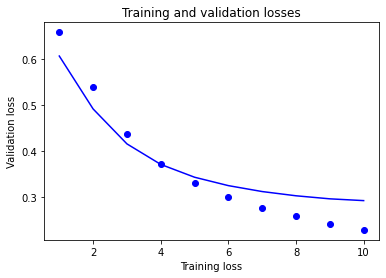

In [ ]:
epochs = range(1, epochs+1)
plt.plot(epochs, train_loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.xlabel('Training loss')
plt.ylabel('Validation loss')
plt.title('Training and validation losses')
plt.show()

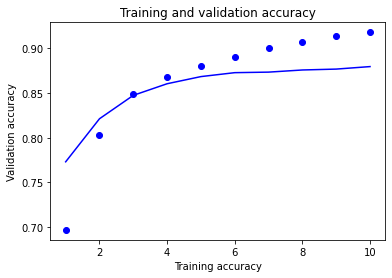

In [ ]:
plt.plot(epochs, train_acc, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.xlabel('Training accuracy')
plt.ylabel('Validation accuracy')
plt.title('Training and validation accuracy')
plt.show()

In [ ]:
 exported_model = tf.keras.Sequential([vectorize_layer,
                                       model,
                                       layers.Activation('sigmoid')])

In [ ]:
exported_model.compile(optimizer='adam', loss=losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])

In [ ]:
loss, accuracy = exported_model.evaluate(raw_test_ds)

782/782 [==============================] - 10s 13ms/step - loss: 0.3405 - accuracy: 0.8650


In [ ]:
loss

0.3404529392719269

In [ ]:
accuracy

0.8650400042533875